## Baseline Model
This notebook can be used to make changes to the parameter files of the baseline model and to easily see the effects of the individual step of the registration process.

In [ ]:
# Library imports
import matplotlib.pyplot as plt
import imageio.v3 as iio
import numpy as np
import elastix
import os

# General file paths - Change based on own directory!
BASE_PATH = "../DevelopmentData"
PATIENT_PATHS = [os.path.join(BASE_PATH, f) for f in os.listdir(BASE_PATH) if not f.startswith('.')]
ELASTIX_PATH = os.path.join(r'C:/Users/20212077/OneDrive - TU Eindhoven/Desktop/8DM20 - Capita Selecta Medical Imaging/elastix-5.0.0-win64/elastix.exe')
TRANSFORMIX_PATH = os.path.join(r'C:/Users/20212077/OneDrive - TU Eindhoven/Desktop/8DM20 - Capita Selecta Medical Imaging/elastix-5.0.0-win64/transformix.exe')

if not os.path.exists(ELASTIX_PATH):
    raise IOError('Elastix cannot be found, please set the correct ELASTIX_PATH.')
if not os.path.exists(TRANSFORMIX_PATH):
    raise IOError('Transformix cannot be found, please set the correct TRANSFORMIX_PATH.')

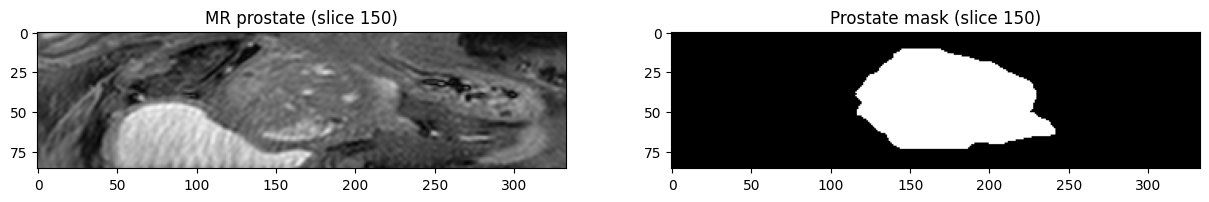

In [12]:
# Load all patient data
mr_prostate_data = []
mask_data = []
for path in PATIENT_PATHS:
    # Individual path per patient
    prostate_path = os.path.join(path, "mr_bffe.mhd")
    mask_path = os.path.join(path, "prostaat.mhd")
    # Store image data in list
    mr_prostate_data.append(iio.imread(prostate_path))
    mask_data.append(iio.imread(mask_path))

# Convert to numpy array
mr_prostate_data = np.array(mr_prostate_data)
mask_data = np.array(mask_data)

# Show example of patient data
slice = 150
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(mr_prostate_data[2,:,:,slice], cmap="gray")
ax[0].set_title(f"MR prostate (slice {slice})")
ax[1].imshow(mask_data[2,:,:,slice], cmap="gray")
ax[1].set_title(f"Prostate mask (slice {slice})");

## 1 - Rigid Registration
In this first step of the registration process, a rough alignment is created between the MR images with rigid registration. The following registration technique is partly based on the following research:

Klein, S., van der Heide, U.A., Lips, I.M., van Vulpen, M., Staring, M. and Pluim, J.P.W. (2008), Automatic segmentation of the prostate in 3D MR images by atlas matching using localized mutual information. Med. Phys., 35: 1407-1417. https://doi.org/10.1118/1.2842076

In [3]:
# Make a results directory if non exists
if os.path.exists("results_baseline/rigid") is False:
    os.mkdir(os.path.join("results_baseline/rigid"))

# Define the patient index for "fixed" and "moving"
fixed_image_idx = 0
moving_image_idx = 1

# Fixed image
fixed_image_path = os.path.join(PATIENT_PATHS[fixed_image_idx], "mr_bffe.mhd")
fixed_image_mask_path = os.path.join(PATIENT_PATHS[fixed_image_idx], "prostaat.mhd")
fixed_image = mr_prostate_data[fixed_image_idx,...]
fixed_image_mask = mask_data[fixed_image_idx,...]

# Moving image
moving_image_path = os.path.join(PATIENT_PATHS[moving_image_idx], "mr_bffe.mhd")
moving_image_mask_path = os.path.join(PATIENT_PATHS[moving_image_idx], "prostaat.mhd")
moving_image = mr_prostate_data[moving_image_idx,...]
moving_image_mask = mask_data[moving_image_idx,...]

# Define a new elastix object 'el' with the correct path to elastix
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

# Execute the registration. Make sure the paths below are correct
el.register(
    fixed_image=fixed_image_path,
    moving_image=moving_image_path,
    parameters=["parameters_baseline_rigid.txt"],
    output_dir="results_baseline/rigid"
)

C:/Users/20212077/OneDrive - TU Eindhoven/Desktop/8DM20 - Capita Selecta Medical Imaging/elastix-5.0.0-win64/elastix.exe -f ../DevelopmentData\p102\mr_bffe.mhd -m ../DevelopmentData\p107\mr_bffe.mhd -p parameters_baseline_rigid.txt -out results_baseline/rigid


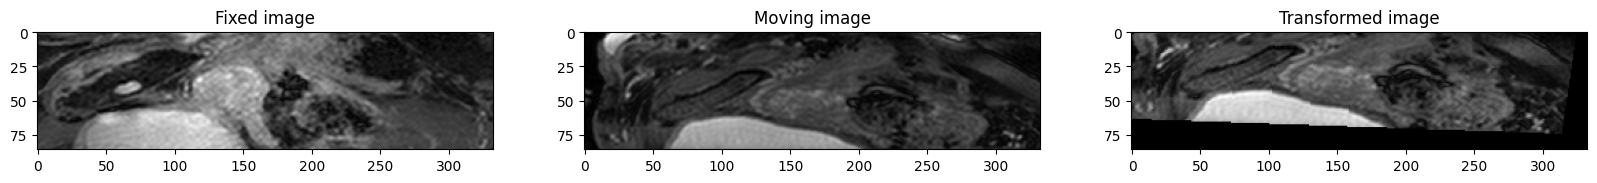

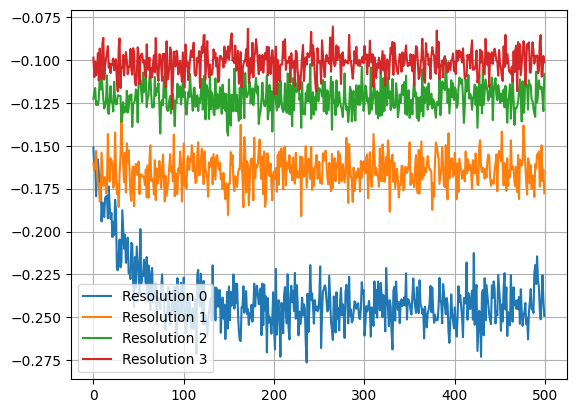

In [4]:
# Find result
transformed_image_path = os.path.join('results_baseline/rigid', 'result.0.mhd')
transformed_image = iio.imread(transformed_image_path)

# Plot the result
slice = 150
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(fixed_image[:,:,slice], cmap='gray')
ax[0].set_title('Fixed image')
ax[1].imshow(moving_image[:,:,slice], cmap='gray')
ax[1].set_title('Moving image')
ax[2].imshow(transformed_image[:,:,slice], cmap='gray')
ax[2].set_title('Transformed image');

# Open the logfile into the dictionary log
fig,ax = plt.subplots(1,1)
for i in range(4):
    log_path = os.path.join('results_baseline/rigid', 'IterationInfo.0.R{}.txt'.format(i))
    log = elastix.logfile(log_path)
    # Plot the 'metric' against the iteration number 'itnr'
    ax.plot(log['itnr'], log['metric'])
ax.legend(['Resolution {}'.format(i) for i in range(4)])
ax.grid()

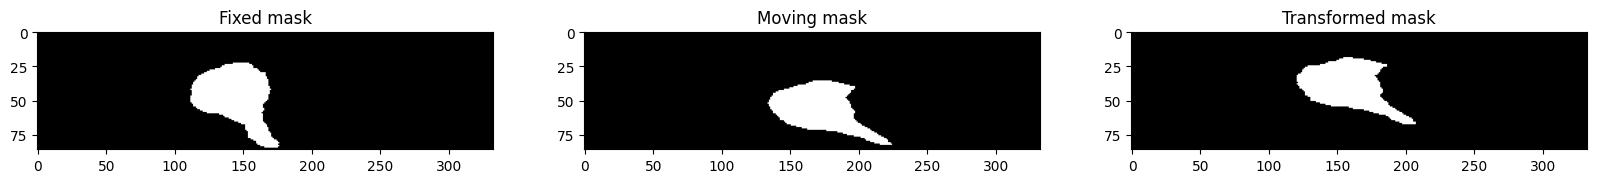

In [5]:
# Define path to transform parameters
transform_path = os.path.join('results_baseline/rigid', 'TransformParameters.0.txt')

# Make a new transformix object tr with the CORRECT PATH to transformix
tr = elastix.TransformixInterface(parameters=transform_path,
                                  transformix_path=TRANSFORMIX_PATH)

# Transform the mask with the transformation parameters
transformed_mask_path = tr.transform_image(moving_image_mask_path, output_dir=os.path.join('results_baseline/rigid'))

# Plot result of the prostate segmentations
transformed_image_mask = iio.imread(transformed_mask_path)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(fixed_image_mask[:,:,slice], cmap="gray")
ax[0].set_title('Fixed mask')
ax[1].imshow(moving_image_mask[:,:,slice], cmap="gray")
ax[1].set_title('Moving mask')
ax[2].imshow(transformed_image_mask[:,:,slice], cmap="gray");
ax[2].set_title('Transformed mask');

## 2 - Nonlinear Registration
After rough alignment, a nonrigid registration is performed using a coordinate transformation that is parameterized by cubic B-splines.

In [ ]:
# Make a results directory if non exists
if os.path.exists("results_baseline/nonlinear") is False:
    os.mkdir(os.path.join("results_baseline/nonlinear"))

# Moving image
moving_image_path = transformed_image_path
moving_image_mask_path = transformed_mask_path
moving_image = transformed_image
moving_image_mask = transformed_image_mask

# Execute the registration. Make sure the paths below are correct
el.register(
    fixed_image=fixed_image_path,
    moving_image=moving_image_path,
    parameters=["parameters_baseline_nonlinear.txt"],
    output_dir="results_baseline/nonlinear"
)

C:/Users/20212077/OneDrive - TU Eindhoven/Desktop/8DM20 - Capita Selecta Medical Imaging/elastix-5.0.0-win64/elastix.exe -f ../DevelopmentData\p102\mr_bffe.mhd -m results_baseline/rigid\result.0.mhd -p parameters_baseline_nonlinear2.txt -out results_baseline/nonlinear


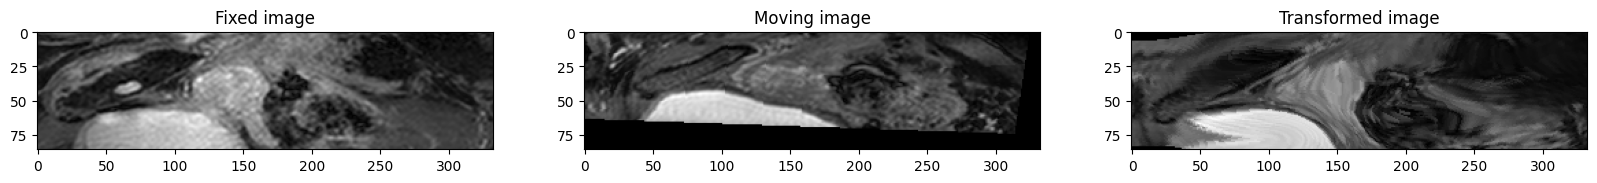

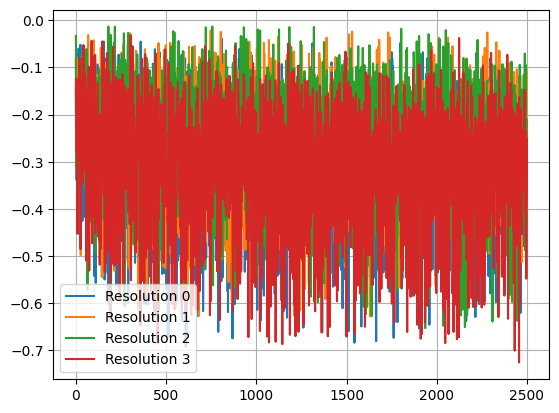

In [7]:
# Find result
transformed_image_path = os.path.join('results_baseline/nonlinear', 'result.0.mhd')
transformed_image = iio.imread(transformed_image_path)

# Plot the result
slice = 150
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(fixed_image[:,:,slice], cmap='gray')
ax[0].set_title('Fixed image')
ax[1].imshow(moving_image[:,:,slice], cmap='gray')
ax[1].set_title('Moving image')
ax[2].imshow(transformed_image[:,:,slice], cmap='gray')
ax[2].set_title('Transformed image');

# Open the logfile into the dictionary log
fig,ax = plt.subplots(1,1)
for i in range(4):
    log_path = os.path.join('results_baseline/nonlinear', 'IterationInfo.0.R{}.txt'.format(i))
    log = elastix.logfile(log_path)
    # Plot the 'metric' against the iteration number 'itnr'
    ax.plot(log['itnr'], log['metric'])
ax.legend(['Resolution {}'.format(i) for i in range(4)])
ax.grid()

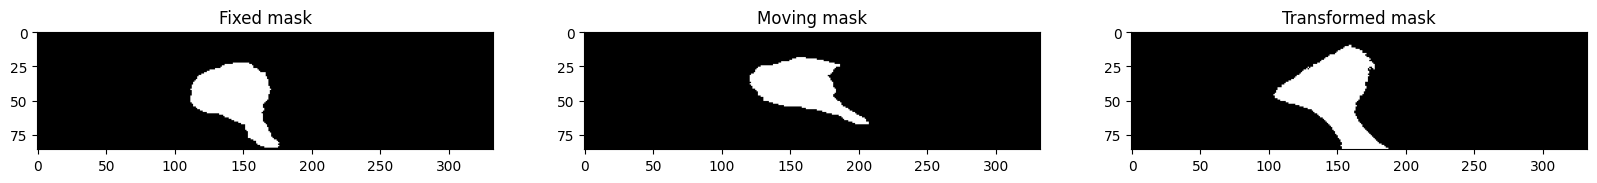

In [ ]:
# Define path to transform parameters
transform_path = os.path.join('results_baseline/nonlinear', 'TransformParameters.0.txt')

# Make a new transformix object tr with the CORRECT PATH to transformix
tr = elastix.TransformixInterface(parameters=transform_path,
                                  transformix_path=TRANSFORMIX_PATH)

# Transform the mask with the transformation parameters
transformed_mask_path = tr.transform_image(moving_image_mask_path, output_dir=os.path.join('results_baseline/nonlinear'))

# Plot result of the prostate segmentations
transformed_image_mask = iio.imread(transformed_mask_path)
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].imshow(fixed_image_mask[:,:,slice], cmap="gray")
ax[0].set_title('Fixed mask')
ax[1].imshow(moving_image_mask[:,:,slice], cmap="gray")
ax[1].set_title('Moving mask')
ax[2].imshow(transformed_image_mask[:,:,slice], cmap="gray");
ax[2].set_title('Transformed mask');

## Dice coefficient

In [11]:
def dice_coefficient(mask1, mask2):
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape.")
    
    intersection = np.sum(mask1*mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)

    if volume_sum == 0:
        return 1.0  # If both masks are empty, they are considered identical
    
    return 2.0 * intersection / volume_sum

print("Dice coefficient after rigid registration:", dice_coefficient(fixed_image_mask, moving_image_mask))
print("Dice coefficient after nonlinear registration:", dice_coefficient(fixed_image_mask, transformed_image_mask))

Dice coefficient after rigid registration: 0.4619652440397086
Dice coefficient after nonlinear registration: 0.7807850783826169
